<a href="https://colab.research.google.com/github/trilgar/MSM-2021/blob/main/MSM_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt

## Основні константи

In [109]:
num_epochs = 5 
num_classes = 10 
batch_size = 100 
learning_rate = 0.001
DATA_PATH ='/content/datasets'
MODEL_STORE_PATH ='/content/saveloads/'

## Завантаження та нормалізація даних:

Датасет MNIST завантажено з бібліотеки torchvision. Після завантаження дані було трансформовано, а саме: перетворено у тензори для роботи з бібліотекою pytorch а також нормалізовано (це не обов'язково , але бажано для кращого навчання)

In [110]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

DataLoader - зручний інструмент для отримання батчів з датасету (тобто витягати з датасету по 100 картинок за раз для навчання та тестування)


In [111]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Нижче ми створили модель яку будемо навчати. Для того, щоб працювати з стандартними апаратами фреймворку pytorch необхідно, щоб модель наслідувала nn.Module .   
Перший, другий і третій шар у нас складається з згортки (тобто послідовної конволюції, активаційної функції та макспулінгу). Зміну розміру даних можна розрахувати за формулою:  
$out = \frac{input - kernelsize + padding*2}{stride} + 1$  
Підставивши у формулу бачимо, що карти ознак після конволюції не зменшуютсья, але замість одного зображення ми отримуємо 32 карти ознак. Проте після макспулінгу з ядром 2 отримуємо картинки розміром 14 на 14.  
Аналогічно з другої згортки ми отримуємо 64 карти ознак з розміром 7 на 7.   
Третя згортка дає нам 128 карт ознак з розміром 4 на 4 (для того, щоб маспулінг підходив для непарного розміру карти ознак, зробив stride = 1 замість 2).  
Далі ми передаємо отримані карти ознак у повнозв'язний шар з 1000 нейронів та 10 виходами (по одному для кожного класу).  
Розглянемо функцію forward(). Вона перевантажує відповідний метод з nn.Module і саме його putorch оптимізатори будуть використовувати для навчання. У ньому задається порядок виклику щарів. Єдине на що слід звернути увагу - це на

```
out = out.reshape(out.size(0), -1)
```
У данному фрагменті коду ми переводимо наші карти ознак в одновимірний масив. Перед цим наші дані були вигляду $(100, 128, 4, 4)$ , де 100 - кількість елементів у батчі, 128 - кількість карт ознак на виході 3-ї згортки, а 4 на 4 - розмір одної карти ознаки.  
Після перетворення отримуємо форму $(100, 128*4*4)$ , тобто ми перетворили вхідні дані на одновимірний масив для кожного елементу з батчу.

In [112]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6 * 6 * 128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


## Створення екземпляру моделі

In [113]:
model = ConvNet()

## Визначення критерію помилки та оптимізатора, за допомогою якого отримується градієнт

In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Навчання моделі

Нижче приведено алгоритм навчання моделі на навчальній вибірці. Спочатку картинка з вибірки подається в модель, викликається метод forward() і ми отримуємо вихід з вектором оцінок (тобто до якого класу що відноситься). Далі ми вираховуємо похибку моделі порівнюючи передбачений вихід з реальним.  
Після цого починаємо корегування ваг. Для цого визначаємо градієнт та за визначеною похибкою мінімізуємо відхилення. Всі дані ітерації записуємо до масиву для подальшого виведення на графік.

In [115]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))


Epoch [1/5], Step [100/600], Loss: 0.1136, Accuracy: 97.00%
Epoch [1/5], Step [200/600], Loss: 0.1197, Accuracy: 96.00%
Epoch [1/5], Step [300/600], Loss: 0.0662, Accuracy: 97.00%
Epoch [1/5], Step [400/600], Loss: 0.0961, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.0964, Accuracy: 95.00%
Epoch [1/5], Step [600/600], Loss: 0.0378, Accuracy: 99.00%
Epoch [2/5], Step [100/600], Loss: 0.0305, Accuracy: 98.00%
Epoch [2/5], Step [200/600], Loss: 0.0503, Accuracy: 98.00%
Epoch [2/5], Step [300/600], Loss: 0.0307, Accuracy: 99.00%
Epoch [2/5], Step [400/600], Loss: 0.0415, Accuracy: 99.00%
Epoch [2/5], Step [500/600], Loss: 0.1036, Accuracy: 97.00%
Epoch [2/5], Step [600/600], Loss: 0.1035, Accuracy: 98.00%
Epoch [3/5], Step [100/600], Loss: 0.0831, Accuracy: 98.00%
Epoch [3/5], Step [200/600], Loss: 0.0352, Accuracy: 98.00%
Epoch [3/5], Step [300/600], Loss: 0.0545, Accuracy: 97.00%
Epoch [3/5], Step [400/600], Loss: 0.0127, Accuracy: 100.00%
Epoch [3/5], Step [500/600], Loss: 0.03

## Перевірка на тестовій вибірці

Після навчання необхідно протестувати нашу модель на тестовій вибірці. Тут ми так само отримуємо передбачення з моделі та порівнюємо з реальними і вираховуємо точність.

In [116]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on the 10000 test images: 98.88 %


## Збереження моделі

In [117]:
torch.save(model.state_dict(),'conv_net_model.ckpt')

## Графік

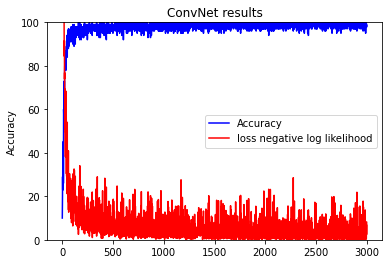

In [118]:
plt.title('ConvNet results')
plt.ylabel("Accuracy")
plt.ylim((0, 100)) 
plt.plot(np.arange(len(loss_list)), np.array(acc_list)*100, color = "blue", label= 'Accuracy')
plt.plot(np.arange(len(loss_list)), np.array(loss_list)*100, color= 'red', label = 'loss negative log likelihood')
plt.legend()
plt.show()